In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error
pd.options.display.width=300
np.set_printoptions(linewidth=500, precision=2)

data = pd.read_csv('data/data.csv')[['DATE', 'T2M']]
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data.set_index('DATE', inplace=True)

# Train, test split
test_ratio = 0.2
train_idx = int(len(data) * (1. - test_ratio))
train = data.loc[data.index[:train_idx]]
test = data.loc[data.index[train_idx:]]

In [2]:
def build_dataset(data, n_lookback):
    X, Y = [], []
    for i in range(len(data) - n_lookback):
        x = data['T2M'][i:i + n_lookback].values
        y = data['T2M'][i + n_lookback]
        X.append(x)
        Y.append(y)
    X = np.vstack(X)
    Y = np.vstack(Y)
    dataset = np.hstack([X,Y])
    dataset = pd.DataFrame(
        data=dataset,
        columns=['t%d' % (i+1) for i in range(n_lookback)] + ['y']
    )
    return dataset

n_lookback = 14
train_set = build_dataset(train, n_lookback)
test_set = build_dataset(test, n_lookback)
train_set.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


/Users/thanakorn/opt/anaconda3/envs/time-series-forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`


,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,y
t1,1.00,0.93,0.84,0.77,0.73,0.71,0.69,0.67,0.66,0.66,0.65,0.65,0.64,0.64,0.63
t2,0.93,1.00,0.93,0.84,0.77,0.73,0.71,0.69,0.68,0.66,0.66,0.65,0.65,0.64,0.64
t3,0.84,0.93,1.00,0.93,0.83,0.77,0.73,0.71,0.69,0.68,0.66,0.66,0.65,0.65,0.64
t4,0.77,0.84,0.93,1.00,0.93,0.83,0.77,0.73,0.71,0.69,0.68,0.67,0.66,0.65,0.65
t5,0.73,0.77,0.83,0.93,1.00,0.93,0.83,0.77,0.73,0.71,0.69,0.68,0.67,0.66,0.65
t6,0.71,0.73,0.77,0.83,0.93,1.00,0.93,0.83,0.77,0.73,0.71,0.69,0.68,0.67,0.66
t7,0.69,0.71,0.73,0.77,0.83,0.93,1.00,0.93,0.83,0.77,0.73,0.71,0.69,0.68,0.67
t8,0.67,0.69,0.71,0.73,0.77,0.83,0.93,1.00,0.93,0.84,0.77,0.73,0.71,0.69,0.68
t9,0.66,0.68,0.69,0.71,0.73,0.77,0.83,0.93,1.00,0.93,0.84,0.77,0.73,0.71,0.69
t10,0.66,0.66,0.68,0.69,0.71,0.73,0.77,0.84,0.93,1.00,0.93,0.84,0.77,0.73,0.71


Text(0, 0.5, 'Actual')

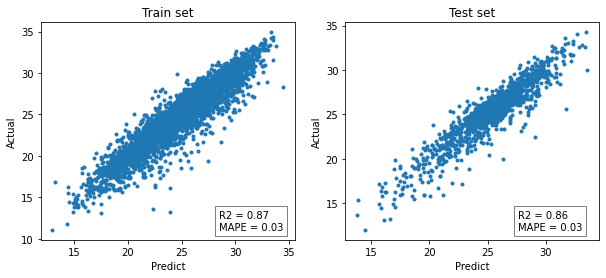

In [3]:
# Train model & evaluate performance
train_x, train_y = train_set.values[:,:-1], train_set.values[:,-1]
test_x, test_y = test_set.values[:,:-1], test_set.values[:,-1]
model = LinearRegression()
model.fit(train_x, train_y)

train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
train_r2, train_mape = r2_score(train_y, train_predict), mean_absolute_percentage_error(train_y, train_predict)
test_r2, test_mape = r2_score(test_y, test_predict), mean_absolute_percentage_error(test_y, test_predict)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Train set')
plt.scatter(train_predict, train_y, marker='.')
plt.text(train_predict.max() - 6., train_y.min(), 'R2 = {:.2f}\nMAPE = {:.2f}'.format(train_r2, train_mape), bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.subplot(122)
plt.title('Test set')
plt.scatter(test_predict, test_y, marker='.')
plt.text(test_predict.max() - 6., test_y.min(), 'R2 = {:.2f}\nMAPE = {:.2f}'.format(test_r2, test_mape), bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Predict')
plt.ylabel('Actual')

[[30.65 32.01 27.16 26.05 28.79 30.01 29.2  30.15 28.62 27.87 28.55 26.67 28.67 27.47]]
<class 'numpy.ndarray'>


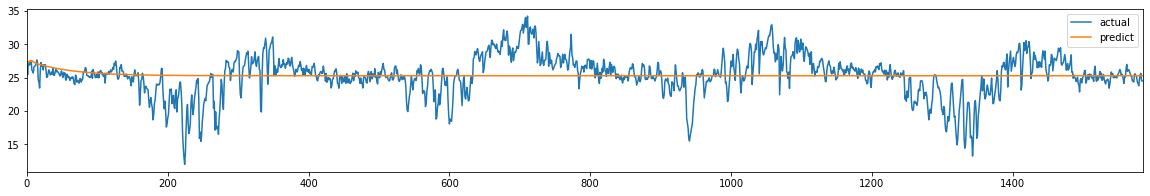

In [5]:
# Make prediction
x = np.expand_dims(data[train_idx - n_lookback:train_idx]['T2M'].values, axis=0)
pred = []
for i in range(len(test)):
    p = model.predict(x)
    x = np.hstack([x[:,1:], np.expand_dims(p, axis=0)])
    pred.append(p)

predictions = np.array(pred)

fig, ax = plt.subplots(figsize=(20,3))
plt.plot(range(len(test)), test, label='actual')
ax.plot(range(len(test)), predictions, label='predict')
plt.xlim((0, len(test)))
plt.legend()

In [22]:
test

,T2M
DATE,
2017-05-10,26.58
2017-05-11,25.48
2017-05-12,27.39
2017-05-13,26.90
2017-05-14,26.94
...,...
2021-09-06,24.78
2021-09-07,25.47
2021-09-08,25.67
